In [1]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

In [2]:
# pip install scikit-learn

### Brief section of LOCAL K-Means (and related) functions:

In [3]:
def localPlusPlusInit(points, k): 
    #print('pointsshape: ', points.shape)
    '''
    points is a numpy array (n,dim)
    '''
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]
    for _ in range(k):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)
        C=np.vstack((C, nextCentroid))
    return C
#Inventare test

In [4]:
# Function to compute weighted average, given 
def weightedAverage(group):
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages
def localLloyds(points, k, weights=None, n_iterations=100):
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    C=localPlusPlusInit(points, k)
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1), axis=1)
        #print(clusterId)
        
    return C_array   

### Beginning of the PARALLELIZED section

In [5]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

24/07/03 15:43:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# create a spark context
sc = spark.sparkContext

In [7]:
data = fetch_kddcup99(return_X_y = True)

In [8]:
len(data[0])

494021

In [9]:
x= data[0]
x = x[:, 4:]

In [10]:
print(x.shape)

(494021, 37)


In [11]:
y = data[1] 

In [12]:
# to delete later on
subLen = 1000
x = x[:subLen,]
y = y[:subLen]

In [13]:
for i in range (x.shape[1]):
    print(len(np.unique(x[:, i])))
    


310
557
1
1
1
10
1
2
2
2
1
1
3
1
2
1
1
2
40
46
7
7
1
1
3
3
36
180
151
67
31
34
23
8
3
1
1


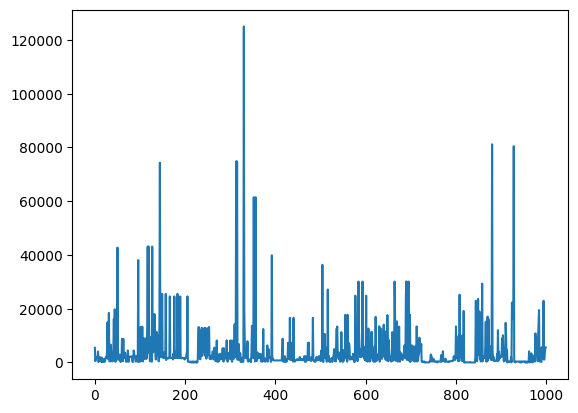

In [14]:
plt.plot(x[:,1])

In [15]:
kTarget = len(set(y))
nSamples = x.shape[0]
print(kTarget)

2


In [16]:
nSlice = None
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(nSamples)], numSlices = nSlice)
# add persist later on
print(Rdd.takeSample(False, 3)[0][1]['x'].shape)

(37,)


In [17]:
Rdd.getNumPartitions() # check partitions

8

In [18]:
def minmaxRescale(datum, minS, maxS):
    mask = (minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]})   



In [19]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

print(maxS.shape)
print((minS < maxS).astype(bool))

(37,)
[ True  True False False False  True False  True  True  True False False
  True False  True False False  True  True  True  True  True False False
  True  True  True  True  True  True  True  True  True  True  True False
 False]
CPU times: user 5.56 ms, sys: 3.09 ms, total: 8.66 ms
Wall time: 418 ms


In [20]:
a,b=np.array([1,3,5]), np.array([2,1,5])
print(np.maximum(a,b))

[2 3 5]


In [21]:
print(*zip(minS, maxS))
print((minS < maxS).astype(bool).shape)

(0, 19721) (0, 125015) (0, 0) (0, 0) (0, 0) (0, 30) (0, 0) (0, 1) (0, 2) (0, 1) (0, 0) (0, 0) (0, 2) (0, 0) (0, 1) (0, 0) (0, 0) (0, 1) (1, 41) (1, 57) (0.0, 0.25) (0.0, 0.25) (0.0, 0.0) (0.0, 0.0) (0.33, 1.0) (0.0, 1.0) (0.0, 1.0) (1, 255) (1, 255) (0.06, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 0.1) (0.0, 0.13) (0.0, 0.0) (0.0, 0.0)
(37,)


In [22]:
#### fix ####
# %%time
# results = Rdd.map(lambda datum: datum["x"])\
#               .reduce(lambda a, b: (np.maximum(a[0], b[0]), np.minimum(a[1], b[1]))

In [23]:
Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))
print(Rdd.takeSample(False, 3)[0][1]['x'].shape)


(24,)


In [24]:
local_datum=Rdd.takeSample(False, 3)[0]
print(local_datum)

(None, {'x': array([0.015212210334161553, 0.3419349678038635, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.075, 0.07142857142857142, 0.0, 0.0, 1.0, 0.0, 0.4,
       0.06692913385826772, 1.0, 1.0, 0.0, 0.06, 0.06, 0.0, 0.0],
      dtype=object), 'y': b'normal.', 'd2': None})


In [25]:
def selectCluster(datum, C, updateDistances=True):
    """
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])

In [26]:
'''
C_init=naiveInitFromSpace(14, len(local_datum[1]['x']))
print(C_init.shape)
'''

"\nC_init=naiveInitFromSpace(14, len(local_datum[1]['x']))\nprint(C_init.shape)\n"

In [27]:
'''
C_init=[el for el in C_init]
print(selectCluster(local_datum, C_init))
'''

'\nC_init=[el for el in C_init]\nprint(selectCluster(local_datum, C_init))\n'

In [28]:
#update centroids as 'centers of mass' of clusters
def updateCentroids(Rdd):
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


In [29]:
#lets assume entry of xy dictionary to be distance of point from its centroid
# ADD IF NOT TIME CONSUMING d ENTRY IN XY DICTIONARY FOR CONSISTENCY

#update the Rdd with square distances from centroids, given Rdd with centroids already updated 
def updateDistances(Rdd, C):
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd
#calculate global cost of X,C from an Rdd with distances from centroids already updated
def cost(Rdd):
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
       .reduce(lambda a,b: a+b)
    return my_cost 

In [30]:
#updateDistances(Rdd, Rdd.takeSample(False, 1)[0][1]['x']).takeSample(False, 10)

In [53]:
def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    kMeans in parallel (?)
    """
    my_kMeansCosts = []
    tIterations = []
    C=C_init
    for t in range(maxIterations):
        t1 = time()
        Rdd = Rdd.map(lambda datum: selectCluster(datum, C))
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(Rdd)
        my_cost = cost(Rdd)
        my_kMeansCosts.append(my_cost)
        t2 = time()
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        
    return C

Different initialization functions

In [32]:
def naiveInitFromSet(Rdd, k):
    #uniform sampling of k points from Rdd
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])
    return C_init
def naiveInitFromSpace(k, dim):
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    C_init=np.random.uniform(size=(k,dim))
    return C_init

In [33]:
def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    """
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C)
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1

    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)

    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
    return C_init
    

In [34]:
arr=np.zeros(5)
print(arr)
tuplas=[(3,2),(4,1),(2,12)]
untuplas=list(zip(*tuplas))
print(untuplas)
arr[[untuplas[0]]]=[untuplas[1]]
print(arr)

[0. 0. 0. 0. 0.]
[(3, 4, 2), (2, 1, 12)]
[ 0.  0. 12.  2.  1.]


In [35]:
#print(naiveInitFromSet(Rdd, 14).shape)
#print(Rdd.takeSample(False, 3)[0][1]['x'])

In [36]:
logParallelInit = {}
logParallelKmeans = {}

In [54]:
%%time
k=kTarget
l=k*2 # rescaling probability to have more centroids than k

# inizialize the centroids with kmeans parallel and compute C after the iterations
C_init = parallelInit(Rdd, k, l, logParallelInit)
C = kMeans(Rdd, C_init, 15, logParallelKmeans)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C))

/tmp/ipykernel_69541/2296267399.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_69541/2296267399.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weightedAverage)\
/tmp/ipykernel_69541/2296267399.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

CPU times: user 561 ms, sys: 47.1 ms, total: 608 ms
Wall time: 15.6 s


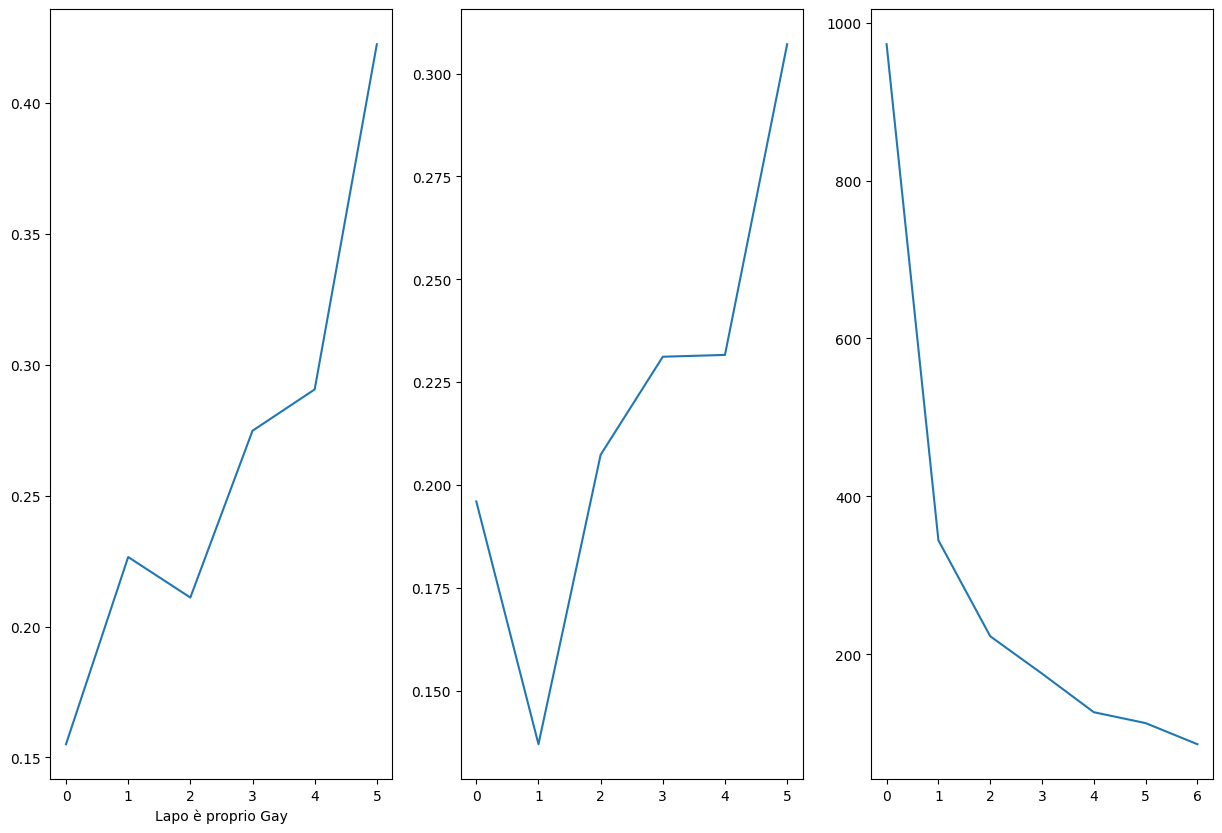

In [58]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(logParallelInit["tCentroids"])
ax[1].plot(logParallelInit["tSamples"])
ax[2].plot(logParallelInit["CostInit"])

In [ ]:
logParallel

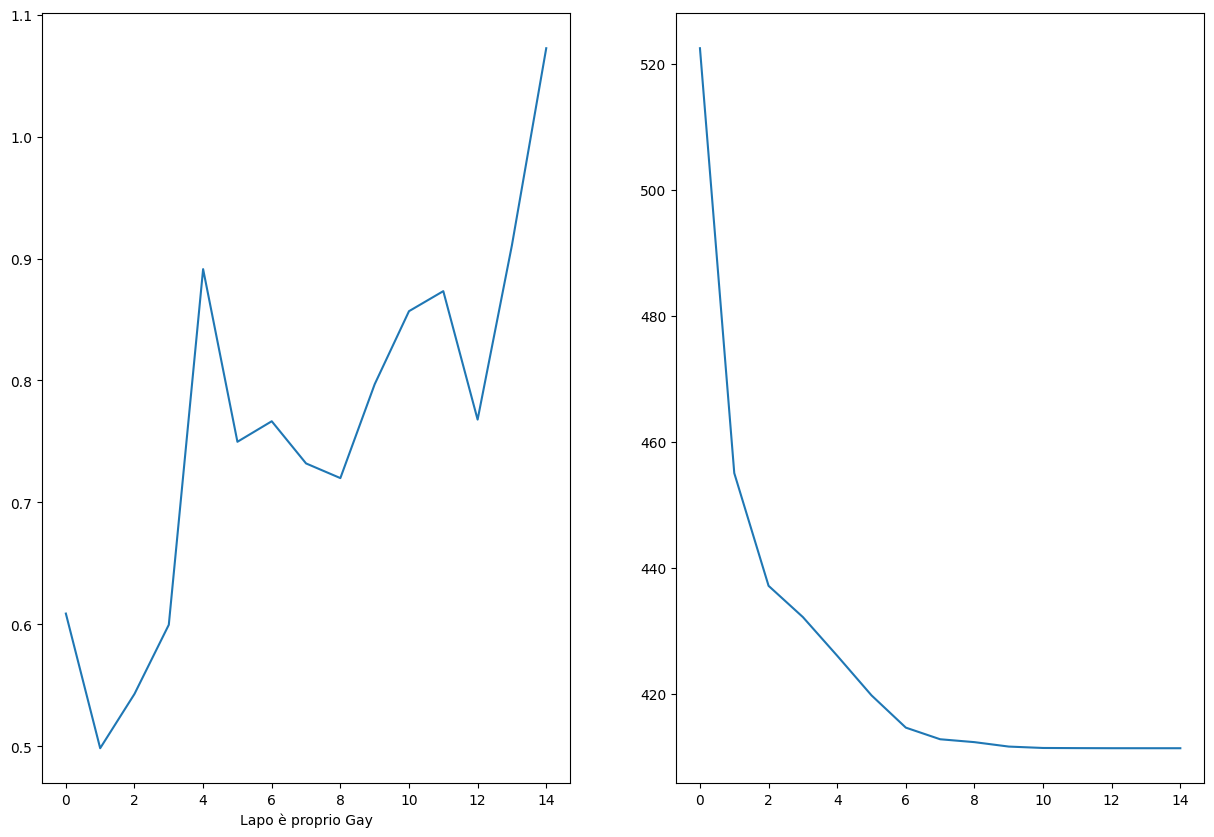

In [57]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(logParallelKmeans["tIterations"])
ax[1].plot(logParallelKmeans["CostsKmeans"])

In [39]:
'''
a=np.array([[1],[2],[3]])
b= np.array([[4],[5],[6]])
print(a*b)
'''
D=np.array([[1,2,3,1],[1,2,3,1],[4,5,6,4],[9,8,7,9]])
print(type(D), D.shape)
print(np.unique(D, axis=0))

<class 'numpy.ndarray'> (4, 4)
[[1 2 3 1]
 [4 5 6 4]
 [9 8 7 9]]


### TODO: compute percentage of coincidence with theoretical "y" clusterId of points

In [40]:
plt.plot(my_parallelInitCosts)
plt.show()
print('costs',my_parallelInitCosts)
print(len(my_parallelInitCosts))
plt.plot(my_kMeansCosts)
plt.show()
for C in my_Cs:
    print(C.shape)
    '''
    for point in C:
        plt.bar(np.arange(len(point)), point)
    plt.show()
    '''
#print('costfromdistsum: ', sum(my_distances[0]))
for pop in my_populations:
    print(pop)
'''
for dist in my_distances:
    #print(dist)
    plt.plot(dist)
    plt.show()
''' 

NameError: name 'my_parallelInitCosts' is not defined

Now we want to write a function to test the agreement between expected cluster labels "y" and resulted labels clusterId